In [6]:
# check the kernel running in the notebook
# !uname -a
# find the variables in the notebook
# %whos

Interactive namespace is empty.


In [7]:
import random
import tqdm
import logging
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RepeatedKFold, KFold, StratifiedKFold

In [8]:
def encode_seqCDR(seqCDR):
    encoding_list = []
    for i in range(len(seqCDR)):
        if seqCDR[i] == "*":
            encoding_list.append(np.zeros(5).reshape(1,5))
        elif seqCDR[i] == "_":
            # print("Error: seqCDR contains '_'")
            # encoding_list.append(np.zeros(5).reshape(1,5))
            return np.nan
        else:
            encoding_list.append(af.loc[seqCDR[i]].values.reshape(1,5))
    return np.array(encoding_list).reshape(1,-1)

af = pd.read_csv("~/data/project/pMHC-TCR/library/Atchley_factors.csv")
af.index = af["Amino acid"]
af.drop(columns=["Amino acid"], inplace=True)

In [9]:
class TCR_encode_data(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path, index_col=0)
        df["Neo_first3"] = df["NeoAA"].str[:3]
        df["Neo_last3"] = df["NeoAA"].str[-3:]
        df = df.drop(columns=["NeoAA"])

        # encode the Neo_first3, Neo_last3
        for seq in ["Neo_first3", "Neo_last3"]:
            df[seq] = df[seq].apply(lambda x: encode_seqCDR(x))

        # drop the rows with duplicate CDR3 sequences
        df = df.drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep="first")
        
        # drop the rows with length == max length, which is much longer than the others
        df = df.loc[df["AseqCDR3"].str.len() < 50, :]

        # encode the CDR3 region
        len_map = {
            "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
            "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
        }
        print(len_map)
        for chain in ["AseqCDR3", "BseqCDR3"]:
            length = len_map[chain]
            df[chain] = df[chain].apply(
                lambda x: x + "*" * (length - len(x)))
            df[chain] = df[chain].apply(lambda x: encode_seqCDR(x))
        
        # If there is any NaN value, drop the row
        df = df.dropna()
        print(df.shape)

        # concatenate the encoded features
        X_features = torch.zeros((len(df),0))
        for seq in ["AseqCDR3", "BseqCDR3"]:
            X_features = torch.cat((X_features, 
            torch.from_numpy(np.vstack(df[seq].values))), dim=1)

        y = df["Class"].apply(lambda x: 1 if x == "positive" else 0).values
        
        # discard the duplicate rows, keep the first one
        self.X_features = X_features
        self.y = torch.from_numpy(y).float()
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_features[idx], self.y[idx]

In [10]:
class TCR_autoencoder(nn.Module):
    '''
    The autoencoder for TCR sequence.
    For 230221 dataset, the sequnce length is 41 (20+21), and the input size is 41*5,
    the hidden size is 10. And the output size is 41*5. We apply convolutional neural
    network to encode the sequence, and apply deconvolutional neural network to decode
    the sequence. The activation function for convolutional neural network is ReLU,
    because it is a non-linear function, and it is easy to calculate the gradient.
    For the decoder, we use the same activation function as the encoder.

    Param:
        input_size: the input size of the autoencoder
        hidden_size: the hidden size of the autoencoder
        output_size: the output size of the autoencoder, which is the same as the input size
    '''
    def __init__(self, kernel_size=3, stride=2, padding=1, batch_size=16):
        super(TCR_autoencoder, self).__init__()
        self.batch_size = batch_size
        self.encoder = nn.Sequential(
            # (batch_size, 5, 49)
            nn.Conv1d(5, 10, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 10, 25) based on the formula for conv1d: (W + 2P - K)/S + 1 = (49 + 2*1 - 3)/2 + 1 = 25
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1),
            # (batch_size, 10, 23), 25 - 2 = 23 

            nn.Conv1d(10, 15, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 20, 12) based on the formula for conv1d: (W + 2P - K)/S + 1 = (23 + 2*1 - 3)/2 + 1 = 12
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1),
            # (batch_size, 20, 10), 12 - 2 = 10

            nn.Conv1d(15, 20, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 20, 5) based on the formula for conv1d: (W + 2P - K)/S + 1 = (10 + 2*1 - 3)/2 + 1 = 5
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1),
            # (batch_size, 20, 3)
        )

        self.decoder = nn.Sequential(
            # (batch_size, 20, 3)
            nn.ConvTranspose1d(20, 15, kernel_size=3, stride=3, padding=1),
            # (batch_size, 15, 5), based on the formula for convtranspose1d: (W−1)S−2P+F = (3-1)*3-2*1+3= 7
            nn.LeakyReLU(),

            nn.ConvTranspose1d(15, 10, kernel_size=7, stride=3, padding=1),
            # (batch_size, 10, 23) based on the formula for convtranspose1d: (W−1)S−2P+F = (7-1)*3-2*1+7= 23
            nn.LeakyReLU(),

            nn.ConvTranspose1d(10, 5, kernel_size=7, stride=2, padding=1),
            # (batch_size, 5, 49) based on the formula for convtranspose1d: (W−1)S−2P+F = (23-1)*2-2*1+7= 49
            nn.LeakyReLU(),
        )

    def forward(self, input):
        # x = torch.tensor(x, dtype=np.float32)
        # x = torch.tensor(x, dtype=torch.float)
        x = input.float()
        encoded = self.encoder(x)
        # print(f"encoding shape: {encoded.shape}")
        encoded = encoded.float()
        output = self.decoder(encoded)
        # print(f"output shape: {output.shape}")
        return encoded, output

In [11]:
file_path = "~/data/project/data/seqData/20230228.csv"
TCRData = TCR_encode_data(file_path)

{'AseqCDR3': 25, 'BseqCDR3': 24}
(2492, 6)


Train Epoch: 1 [0/2492 (0%)]	Loss: 1.422211
Train Epoch: 1 [1600/2492 (65%)]	Loss: 1.269276
Train Epoch: 2 [0/2492 (0%)]	Loss: 1.270869
Train Epoch: 2 [1600/2492 (65%)]	Loss: 1.301361
Train Epoch: 3 [0/2492 (0%)]	Loss: 1.353347
Train Epoch: 3 [1600/2492 (65%)]	Loss: 1.198825
Train Epoch: 4 [0/2492 (0%)]	Loss: 1.316884
Train Epoch: 4 [1600/2492 (65%)]	Loss: 1.105351
Train Epoch: 5 [0/2492 (0%)]	Loss: 1.217188
Train Epoch: 5 [1600/2492 (65%)]	Loss: 1.153005
Train Epoch: 6 [0/2492 (0%)]	Loss: 0.985455
Train Epoch: 6 [1600/2492 (65%)]	Loss: 1.065668
Train Epoch: 7 [0/2492 (0%)]	Loss: 1.051921
Train Epoch: 7 [1600/2492 (65%)]	Loss: 1.016856
Train Epoch: 8 [0/2492 (0%)]	Loss: 1.158589
Train Epoch: 8 [1600/2492 (65%)]	Loss: 1.101415
Train Epoch: 9 [0/2492 (0%)]	Loss: 1.090983
Train Epoch: 9 [1600/2492 (65%)]	Loss: 1.065062
Train Epoch: 10 [0/2492 (0%)]	Loss: 1.122251
Train Epoch: 10 [1600/2492 (65%)]	Loss: 1.083244
Train Epoch: 11 [0/2492 (0%)]	Loss: 1.141127
Train Epoch: 11 [1600/2492 (65%)]

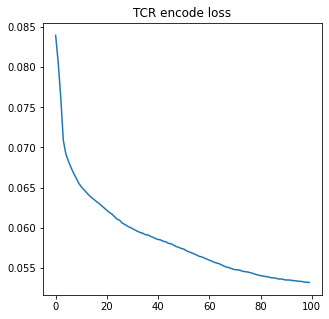

In [12]:
# training the autoencoder to encode the TCR sequence
def train_autoencoder(model, train_loader, optimizer, criterion, epoch, seq_length):
    model.train()
    batch_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.float()
        data = data.view(batch_size, 5, seq_length)
        optimizer.zero_grad()
        _, output = model(data)
        # print(output.shape, data.shape)
        loss = criterion(output, data)
        # TCR_encode_losses.append(loss.item() / model.batch_size)
        # TCR_encode_losses.append(loss.item())
        # sum up batch loss
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    return batch_loss / len(train_loader.dataset)

# parameters setting
epochs = 100
batch_size = 16
learning_rate = 1e-3
kernel_size = 3
stride = 2
padding = 1
seq_length = int(TCRData[0][0].shape[0] / 5)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train the autoencoder
model = TCR_autoencoder(kernel_size=kernel_size, stride=stride, padding=padding, batch_size=batch_size)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()
train_loader = DataLoader(TCRData, batch_size=batch_size, shuffle=True, drop_last=True)

# plot the loss
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

TCR_encode_losses = []
for epoch in range(1, epochs + 1):
    TCR_encode_loss = train_autoencoder(model, train_loader, optimizer, criterion, epoch, seq_length)
    TCR_encode_losses.append(TCR_encode_loss)
ax.set_title("TCR encode loss")
ax.plot(TCR_encode_losses, label="TCR encode loss")

In [13]:
epochs = 100
batch_size = 16
learning_rate = 1e-3
kernel_size = 3
stride = 2
padding = 1

# load the model
# model = TCR_autoencoder(kernel_size=kernel_size, stride=stride, padding=padding, batch_size=batch_size)
# model.load_state_dict(torch.load("/DATA/User/wuxinchao/project/pMHC-TCR/ckpt/TCR_autoencoder.pt"))

model.eval()

# encode the TCR sequence
file_path = "~/data/project/data/seqData/20230228.csv"
TCRData = TCR_encode_data(file_path)
# TCR_loader = DataLoader(TCRData, batch_size=batch_size, shuffle=True, drop_last=True)
TCR_encode = torch.zeros((0, 20, 3))
for i in range(len(TCRData)):
    TCR_seq = TCRData[i][0]
    TCR_seq = TCR_seq.view(1, 5, 49).float()
    encoded, _ = model(TCR_seq)
    TCR_encode = torch.cat((TCR_encode, encoded), dim=0)

{'AseqCDR3': 25, 'BseqCDR3': 24}
(2492, 6)


In [56]:
# for test, not used
model = TCR_autoencoder(kernel_size=kernel_size, stride=stride, padding=padding, batch_size=batch_size)
kernel_size, stride, padding, seq_length
# pool of size=3, stride=2
# m = nn.MaxPool1d(3, stride=1)
# m = nn.Conv1d(16, 33, 3, stride=2, padding=1)
m = nn.ConvTranspose1d(16, 8, kernel_size=3, stride=2, padding=1)
# m = nn.MaxUnpool1d(kernel_size=3, stride=1)
input = torch.randn(20, 16, 3)
output = m(input)
output.shape
# TCRData[0][0].shape
len(TCRData)
# model(TCRData[0:3][0].float().view(3,5,seq_length))

In [66]:
class LSTM_TCR_encode(nn.Module):
    '''
    LSTM for TCR sequence encoding.
    The input size of LSTM is (batch_size, seq_length, input_size), the output size is (batch_size, seq_length, hidden_size)
    '''
    def __init__(self, seq_length, hidden_size, num_layers, device):
        super(LSTM_TCR_encode, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.lstm = nn.LSTM(seq_length, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        x = x.float()
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(self.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        return out

In [9]:
# Train the LSTM model for TCR sequence encoding, this may not be used in the future
# How to use the LSTM model to encode the TCR sequence
# The optimization 
def train_LSTM_TCR_encode(model, train_loader, optimizer, criterion, epoch, seq_length):
    model.train()
    batch_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.float()
        data = data.view(batch_size, seq_length, 5)
        optimizer.zero_grad()
        output = model(data)
        # print(output.shape, data.shape)
        loss = criterion(output, data)
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Training: {batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%) \
                  Loss: {loss.item():.6f}")
    return batch_loss / len(train_loader.dataset)

# parameters setting
epochs = 100
batch_size = 16
learning_rate = 1e-3
hidden_size = 16
num_layers = 2
seq_length = int(TCRData[0][0].shape[0] / 5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train the LSTM model
model = LSTM_TCR_encode(seq_length, hidden_size, num_layers, device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()

In [14]:
class pMHC_TCRDataset(Dataset):
    '''
    The dataset for the encoded features of TCR sequence, and the Atchley factor of neoantigen sequence, and the HLA one-hot encoding.
    Here the input is the TCR sequence, neoantigen sequence, and HLA type.
    The output should be the encoded features of TCR sequence, and the Atchley factor of neoantigen sequence, and the HLA one-hot encoding.
    '''
    def __init__(self, 
                 file_path, 
                 only_CDR3: bool = False, 
                 only_experimental: bool = False, 
                 TCR_encode: str = ["LSTM", "CNN"],
                 encoding_model: nn.Module = None) -> None:
        df, HLA_encode, y  = self.basic_io(file_path, only_experimental=only_experimental)

        # convert from object to tensor
        X_TCR_seq = torch.zeros((len(df), 0))
        for region in ["AseqCDR3", "BseqCDR3"]:
            TCR_seq = df.loc[:, region].values
            TCR_seq_encode = torch.zeros((0, TCR_seq[0].shape[1]))
            for i in range(len(TCR_seq)):
                encoding = torch.from_numpy(TCR_seq[i][0])
                encoding = encoding.reshape(1, -1)
                TCR_seq_encode = torch.cat((TCR_seq_encode, encoding), dim=0)

            X_TCR_seq = torch.cat((TCR_seq_encode, X_TCR_seq), dim=1)
        
        if TCR_encode == "CNN":
            X_TCR_seq = X_TCR_seq.view(-1, 5, 49)
        elif TCR_encode == "LSTM":
            X_TCR_seq = X_TCR_seq.view(-1, 5, 49)
        else:
            raise ValueError("The TCR encoding method is not supported yet.")
        
        # encoding model 
        X_features, _ = encoding_model(X_TCR_seq)
        X_features = X_features.view(-1, 20 * 3).data

        # add the neoantigen sequence encoding features
        for seq in ["Neo_first3", "Neo_last3"]:
            neo = df.loc[:, seq].values
            neo_encode = torch.zeros((0, neo[0].shape[1]))
            for i in range(len(neo)):
                encoding = torch.from_numpy(neo[i][0])
                encoding = encoding.reshape(1, -1)
                neo_encode = torch.cat((neo_encode, encoding), dim=0)
            X_features = torch.cat((X_features, neo_encode), dim=1)

        X_features = torch.cat((X_features, torch.from_numpy(HLA_encode)), dim=1)

        self.X_features = X_features
        self.y = torch.from_numpy(y)
            
    
    def basic_io(self, file_path, only_experimental=True):
        # return the dataframe, contain the 
        df = pd.read_csv(file_path, index_col=0)
        df = df.loc[df["AseqCDR3"].str.len() < 50, :]
        # for chain in ["AseqCDR", "BseqCDR"]:
        #     if only_CDR3:
        #         df[chain+"_3"] = df[chain].str.split("_").str[2]
        #         df.drop(columns=[chain], inplace=True)
        #     else:
        #         df[chain+"_1"] = df[chain].str.split("_").str[0]
        #         df[chain+"_2"] = df[chain].str.split("_").str[1]
        #         df[chain+"_3"] = df[chain].str.split("_").str[2]
        #         df.drop(columns=[chain], inplace=True)
        df["Neo_first3"] = df["NeoAA"].str[:3]
        df["Neo_last3"] = df["NeoAA"].str[-3:]
        df = df.drop(columns=["NeoAA"])

        # encode the Neo_first3, Neo_last3
        for seq in ["Neo_first3", "Neo_last3"]:
            df[seq] = df[seq].apply(lambda x: encode_seqCDR(x))

        # encode the CDR3 region
        len_map = {
            "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
            "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
        }
        for chain in ["AseqCDR3", "BseqCDR3"]:
            length = len_map[chain]
            df[chain] = df[chain].apply(lambda x: x + "*" * (length - len(x)))
            df[chain] = df[chain].apply(lambda x: encode_seqCDR(x))
        
        # drop the rows with nan
        df = df.dropna()

        if not only_experimental:
            df_ps = df[df["Class"] == "positive"]
            df_ng_ex = df[df["Class"] == "negative"]
            df_ng_em = df.copy()
            df_ng_em = df_ng_em[df_ng_em["Class"] == "positive"]
            df_ng_em["AseqCDR_3"] = df_ng_em["AseqCDR_3"].apply(
                lambda x: random.choice(list(set(df_ng_em["AseqCDR_3"]) - set(x))))
            df_ng_em["BseqCDR_3"] = df_ng_em["BseqCDR_3"].apply(
                lambda x: random.choice(list(set(df_ng_em["BseqCDR_3"]) - set(x))))
            df_ng = pd.concat([df_ng_em, df_ng_ex], axis=0)
            df_ng.index = range(len(df_ng))
            df = pd.concat([df_ps, df_ng], axis=0)

        X_HLA = df["HLA"].values.reshape(-1, 1)
        HLAencoder = OneHotEncoder()
        X_HLA_encoded = HLAencoder.fit_transform(X_HLA).toarray()
        
        y = df["Class"].apply(lambda x: 1 if x == "positive" else 0).values

        return df, X_HLA_encoded, y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_features[idx], self.y[idx]

In [15]:
TCRData = pMHC_TCRDataset(file_path, TCR_encode="CNN", only_experimental=True, encoding_model=model)

In [16]:
TCRData[0][0].shape                                                

torch.Size([92])

In [48]:
# for test
df = pd.read_csv(file_path, index_col=0)
df = df.loc[df["AseqCDR3"].str.len() < 50, :]

df["Neo_first3"] = df["NeoAA"].str[:3]
df["Neo_last3"] = df["NeoAA"].str[-3:]
df = df.drop(columns=["NeoAA"])

# encode the Neo_first3, Neo_last3
for seq in ["Neo_first3", "Neo_last3"]:
    df[seq] = df[seq].apply(lambda x: encode_seqCDR(x))

# encode the CDR3 region
len_map = {
    "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
    "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
}
for chain in ["AseqCDR3", "BseqCDR3"]:
    length = len_map[chain]
    df[chain] = df[chain].apply(lambda x: x + "*" * (length - len(x)))
    df[chain] = df[chain].apply(lambda x: encode_seqCDR(x))

# drop the rows with nan
df = df.dropna()

X_HLA = df["HLA"].values.reshape(-1, 1)
HLAencoder = OneHotEncoder()
X_HLA_encoded = HLAencoder.fit_transform(X_HLA).toarray()

y = df["Class"].apply(lambda x: 1 if x == "positive" else 0).values

In [30]:
class prediction_model(nn.Module):
    def __init__(self, 
                 input_size,
                 batch_size=32,) -> None:
        super(prediction_model, self).__init__()
        self.input_size = input_size
        self.batch_size = batch_size
        self.linear_layer = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2),
        )

    def forward(self, input):
        input = input.view(self.batch_size, self.input_size)
        # print(f"The model input shape is : {input.shape}")
        output = self.linear_layer(input)
        return output

In [44]:
def train(fold, model, device, train_loader, optimizer, epoch, criterion):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # one-hot encoding the target
        target = target.to(torch.float32).view(-1, 1)
        target = target.to(torch.bool)
        one_hot_target = torch.zeros((target.shape[0], 2))
        one_hot_target[(target==1).squeeze(), 1] = 1
        one_hot_target[(target==0).squeeze(), 0] = 1

        data, one_hot_target = data.to(device), one_hot_target.to(device)
        data = data.view(-1, 60+5*6+2).to(torch.float32)
        output = model(data)
        loss = criterion(output, one_hot_target.data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred = output.sigmoid().round()
        correct += pred.eq(one_hot_target.view_as(pred)).sum().item()
        train_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f"Training stage for Flod {fold} Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} \
                ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
    return train_loss, correct


def test(fold, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            target = target.to(torch.float32).view(-1, 1)
            target = target.to(torch.bool)
            one_hot_target = torch.zeros((target.shape[0], 2))
            one_hot_target[(target==1).squeeze(), 1] = 1
            one_hot_target[(target==0).squeeze(), 0] = 1
            data, one_hot_target = data.to(device), one_hot_target.to(device)
            data = data.view(-1, 60+5*6+2).to(torch.float32)
            output = model(data)
            one_hot_target = one_hot_target.to(torch.float32).view(-1, 1)
            test_loss += nn.CrossEntropyLoss()(output.reshape(1,-1), one_hot_target.reshape(1,-1)).item()  # sum up loss
            # print(test_loss)
            pred = output.sigmoid().round()
            correct += pred.eq(one_hot_target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    print(f"Test set for fold{fold}: Average Loss: \
          {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} \
          ({100. * correct / len(test_loader.dataset):.0f}%)")
    # print(f"The length of test_loader is {len(test_loader)}")
    return test_loss, correct / len(test_loader.dataset)

Using cuda:0 for training
-------------------Fold 0-------------------
Training stage for Flod 0 Epoch: 1 [0/37476                 (0%)]	Loss: 0.830887
Training stage for Flod 0 Epoch: 1 [3200/37476                 (11%)]	Loss: 0.130566
Training stage for Flod 0 Epoch: 1 [6400/37476                 (21%)]	Loss: 0.032834
Training stage for Flod 0 Epoch: 1 [9600/37476                 (32%)]	Loss: 0.124586
Training stage for Flod 0 Epoch: 1 [12800/37476                 (43%)]	Loss: 0.023386
Training stage for Flod 0 Epoch: 1 [16000/37476                 (53%)]	Loss: 0.266913
Training stage for Flod 0 Epoch: 1 [19200/37476                 (64%)]	Loss: 0.075893
Training stage for Flod 0 Epoch: 1 [22400/37476                 (75%)]	Loss: 0.042342
Training stage for Flod 0 Epoch: 1 [25600/37476                 (85%)]	Loss: 0.001998
Training stage for Flod 0 Epoch: 1 [28800/37476                 (96%)]	Loss: 0.021361
Test set for fold0: Average Loss:           0.7816, Accuracy: 14588/37476    

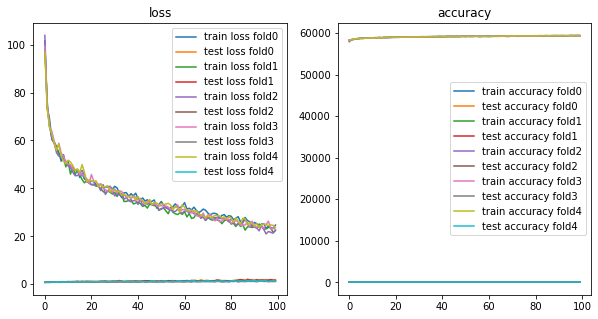

In [45]:
# Training 
batch_size = 32
seq_length = 6
folds = 5
repeats = 12
epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using {device} for training")

def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

model = prediction_model(input_size=92, batch_size=batch_size).to(device)
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
weights = torch.FloatTensor([1,10])
# optimizer = optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss().to(device)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("loss")
ax[1].set_title("accuracy")

for fold, (train_idx, test_idx) in enumerate(kf.split(TCRData.X_features, TCRData.y)):
    print(f"-------------------Fold {fold}-------------------")
    if batch_size == 1:
    # using the subsampler to get the data
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
        train_dataset = torch.utils.data.Subset(TCRData, train_idx)
        test_dataset = torch.utils.data.Subset(TCRData, test_idx)
        train_loader = torch.utils.data.DataLoader(TCRData, batch_size=len(train_dataset), sampler=train_subsampler)
        test_loader = torch.utils.data.DataLoader(TCRData, batch_size=len(test_dataset), sampler=test_subsampler)
    else:
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
        train_loader = torch.utils.data.DataLoader(TCRData, 
            batch_size=batch_size, sampler=train_subsampler, drop_last=True)
        test_loader = torch.utils.data.DataLoader(TCRData, 
            batch_size=batch_size, sampler=test_subsampler, drop_last=True)
        
    model.apply(reset_weights)
    train_losses_history = []
    test_losses_history = []
    train_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(1, epochs+1):
        train_losses, train_correct = train(fold, model, device, train_loader, optimizer, epoch, criterion)
        test_losses, test_correct = test(fold, model, device, test_loader)
        train_losses_history.append(train_losses)
        test_losses_history.append(test_losses)
        train_accuracy_history.append(train_correct)
        test_accuracy_history.append(test_correct)
    # ax[0].plot(train_losses_history, "r*--" ,label=f"train loss fold{fold}")
    # ax[0].plot(test_losses_history, "bs--", label=f"test loss fold{fold}")
    # ax[1].plot(train_accuracy_history, "g^--", label=f"train accuracy fold{fold}")
    # ax[1].plot(test_accuracy_history, "yo--", label=f"test accuracy fold{fold}")
    ax[0].plot(train_losses_history, label=f"train loss fold{fold}")
    ax[0].plot(test_losses_history, label=f"test loss fold{fold}")
    ax[1].plot(train_accuracy_history, label=f"train accuracy fold{fold}")
    ax[1].plot(test_accuracy_history, label=f"test accuracy fold{fold}")
ax[0].legend()
ax[1].legend()
# put the legend out of the figure, and adjust the position, prevent the figure from being covered
# ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# save the figure
# fig.savefig("/DATA/User/wuxinchao/project/pMHC-TCR/result/pMHC_without_em_with_encoder_loss_accuracy.png")

In [39]:
c = torch.randn((32, 92)).to(device)
# # a.shape
d = model(c).to(device)
model.train()
optimizer.zero_grad()
# loss = nn.CrossEntropyLoss()(model(a).to(torch.float32).view(32, 1, 1), torch.ones((32, 1, 1)).to(torch.float32).to(device)) / 32
# loss.to(device)
# loss.backward()
# optimizer.step()
loss_fn = nn.CrossEntropyLoss()
a = torch.randint(0,2,(32,1)) # mask
b = torch.zeros((32,2))
# get the value of b where a is 1
a = a.to(torch.bool)
b[(a==1).squeeze(),1] = 1
b[(a==0).squeeze(),0] = 1

In [49]:
# loss = loss_fn(d, torch.ones((32,2)).to(device))
# loss.backward()
# train_losses_history
# test_losses_history
# test_accuracy_history
train_accuracy_history

[58281,
 58416,
 58542,
 58611,
 58658,
 58702,
 58690,
 58742,
 58743,
 58814,
 58780,
 58782,
 58809,
 58851,
 58811,
 58862,
 58845,
 58924,
 58926,
 58956,
 59000,
 58959,
 58986,
 59007,
 59003,
 59028,
 59011,
 59036,
 59093,
 59022,
 59026,
 59039,
 59058,
 59074,
 59073,
 59092,
 59129,
 59109,
 59126,
 59136,
 59095,
 59103,
 59117,
 59178,
 59150,
 59128,
 59169,
 59169,
 59168,
 59220,
 59168,
 59187,
 59174,
 59140,
 59204,
 59260,
 59192,
 59215,
 59253,
 59172,
 59172,
 59230,
 59222,
 59185,
 59212,
 59218,
 59261,
 59255,
 59297,
 59282,
 59255,
 59293,
 59311,
 59274,
 59273,
 59282,
 59276,
 59299,
 59301,
 59253,
 59271,
 59323,
 59251,
 59325,
 59350,
 59265,
 59328,
 59363,
 59334,
 59329,
 59348,
 59340,
 59357,
 59336,
 59315,
 59335,
 59358,
 59328,
 59318,
 59357]

In [34]:
# loss.backward()
# torch.zeros((32,2))
model(torch.randn((32,92)).to(device))

The model input shape is : torch.Size([32, 92])


tensor([[-0.2870, -0.0434],
        [-0.3169, -0.0655],
        [-0.2865, -0.0411],
        [-0.3154, -0.0643],
        [-0.3112, -0.0605],
        [-0.2862, -0.0417],
        [-0.2947, -0.0502],
        [-0.3223, -0.0679],
        [-0.3114, -0.0614],
        [-0.3071, -0.0575],
        [-0.3100, -0.0598],
        [-0.3044, -0.0542],
        [-0.2960, -0.0493],
        [-0.3085, -0.0567],
        [-0.3342, -0.0772],
        [-0.3270, -0.0721],
        [-0.3018, -0.0537],
        [-0.3169, -0.0647],
        [-0.2889, -0.0440],
        [-0.3067, -0.0579],
        [-0.2876, -0.0417],
        [-0.2872, -0.0405],
        [-0.3142, -0.0639],
        [-0.3049, -0.0558],
        [-0.3075, -0.0570],
        [-0.2959, -0.0517],
        [-0.2968, -0.0511],
        [-0.3162, -0.0621],
        [-0.2941, -0.0467],
        [-0.2973, -0.0524],
        [-0.3051, -0.0581],
        [-0.3202, -0.0669]], device='cuda:0', grad_fn=<AddmmBackward0>)

After encoding, the features are concatanated and used to predict the binding affinity of pMHC-TCR model.

In [19]:
class pMHC_TCR_pred(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, num_layers, device, use_whole_data=False):
        super(pMHC_TCR_pred, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.device = device
        self.use_whole_data = use_whole_data

        # use the encoded features to predict the binding affinity through MLP
        self.Linear_layer = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x):
        x = self.Linear_layer(x)
        return x

In [70]:
class LSTM_encode(nn.Module):
    def __init__(self, input_size, seq_length, hidden_size, batch_size, num_layers, device, use_whole_data=False):
        self.input_size = input_size
        self.seq_length = seq_length
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.device = device
        self.use_whole_data = use_whole_data

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

    def forward(self, x):
        x = x.view(self.batch_size, self.seq_length, self.input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        return out[:, -1, :] # return the last hidden state

In [38]:
df = pd.read_csv(file_path, index_col=0)
df["Neo_first3"] = df["NeoAA"].str[:3]
df["Neo_last3"] = df["NeoAA"].str[-3:]
df = df.drop(columns=["NeoAA"])

# encode the Neo_first3, Neo_last3
for seq in ["Neo_first3", "Neo_last3"]:
    df[seq] = df[seq].apply(lambda x: encode_seqCDR(x))

# encode the CDR3 region
df = df.drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep="first")

len_map = {
    "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
    "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
}
print(len_map)
# drop the rows with length == max length, which is much longer than the others
df = df.loc[df["AseqCDR3"].str.len() < len_map["AseqCDR3"], :]

{'AseqCDR3': 82, 'BseqCDR3': 24}


(array([3.200e+02, 2.288e+03, 2.800e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.100e+01]),
 array([ 5. , 12.6, 20.2, 27.8, 35.4, 43. , 50.6, 58.2, 65.8, 73.4, 81. ]),
 <BarContainer object of 10 artists>)

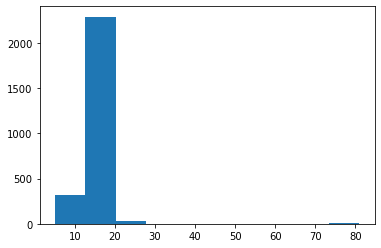

In [43]:
# df["AseqCDR3"].value_counts()
# df["AseqCDR3"].str.len().sort_values(axis=0) # find the longest seq
# df.loc[df["AseqCDR3"].str.len() == 83, "AseqCDR3"]

plt.hist(df["AseqCDR3"].str.len().sort_values(axis=0))
# plt.show()
# df = df.loc[df["AseqCDR3"].str.len() < 83, :]
# df["AseqCDR3"].str.len().sort_values(axis=0)

In [100]:
# len_map
df.to_csv("/home/wuxinchao/data/project/data/seqData/20230228.csv")
# df.loc[df["AseqCDR3"].str.contains("_"),]
# df.shape